<a href="https://colab.research.google.com/github/arnelaguinaldo/arnelaguinaldo/blob/main/Copy_of_ISB_Deep_Learning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **ISB Deep Learning Tutorial**

Eni Halilaj


In this CoLab note, you will experience simple deep neural network algorithm to estimate lower extremities joint angles from IMUs. 

<br><br>
## Step 1. Download prerequisite libraries
There are dependencies (Python libraries) for running the tutorial.
<br>
The code below downloads those dependencies using `pip install` and check GPU availability to for the inference of the neural network.

In [ ]:
print('Download prerequisite libraries! \n\n')

!pip install torch
!pip install numpy
!pip install matplotlib

print('\n\nCheck GPU is available for the neural network')
# Check if CUDA (GPU package) is available in your system
import torch; print(f"\n\nIs CUDA available?: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Download prerequisite libraries! 




Check GPU is available for the neural network


Is CUDA available?: True


If it says **False** for the CUDA availability, go to ``Edit`` - ``Notebook Setting`` and set ``Hardware accelerator`` to **GPU**.

<br><br>
## Step 2. Download pretrained models and test data
We provide pretrained neural network models and input IMUs data for estimating lower body joint angles. 
<br>
By using the code cells below, you can download those files from Google Drive.

In [ ]:
"""Python implementation of downloading files from Google Drive
Reference: https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
"""

import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


# Clear the directory
!rm -rf *

# Download pretrained models and corresponding Python code
print('Download and uncompress pretrained models!')
download_file_from_google_drive('1bJJ_lw9XcaiJB83P5n23A1ojrFRlAqQR', './models.zip')
!unzip models.zip

# Download testset
print('\n\nDownload and uncompress testing data!')
download_file_from_google_drive('1aGzdVEMFmx2-o3-NCsgTkRoSRzvaKBjo', './data.zip')
!unzip data.zip

!rm -rf *.zip
!rm -rf __*

print('\n\nDownload completed!')

Download and uncompress pretrained models!
Archive:  models.zip
   creating: models/
  inflating: models/.DS_Store        
  inflating: __MACOSX/models/._.DS_Store  
  inflating: models/pure_conv.py     
  inflating: models/pure_lstm.py     
   creating: models/checkpoints/
  inflating: models/__init__.py      
   creating: models/checkpoints/Running/
  inflating: models/checkpoints/.DS_Store  
  inflating: __MACOSX/models/checkpoints/._.DS_Store  
   creating: models/checkpoints/Walking/
  inflating: models/checkpoints/Running/.DS_Store  
  inflating: __MACOSX/models/checkpoints/Running/._.DS_Store  
  inflating: models/checkpoints/Running/Ankle_model.pt  
  inflating: models/checkpoints/Running/Knee_model.pt  
  inflating: models/checkpoints/Running/Ankle_model_kwargs.pkl  
  inflating: models/checkpoints/Running/Ankle_norm_dict.pt  
  inflating: models/checkpoints/Running/Hip_model_kwargs.pkl  
  inflating: models/checkpoints/Running/Knee_model_kwargs.pkl  
  inflating: models/check

<br><br>
## Step 3. Choose your model
We provide 2 activities (Walking/Running) and 3 joints (Hip/Knee/Ankle). You can change activity and joint variables below.

In [ ]:
# Select activity and joint you want to predict
print("Choose activity among 'Walking' and 'Running'!")
print("Choose joint among 'Hip', 'Knee', and 'Ankle'!")
activity = 'Walking'
joint = 'Knee'

assert activity in ['Walking', 'Running']
assert joint in ['Hip', 'Knee', 'Ankle']

print('\n'*2 + '#' * 10 + ' Tutorial Setup ' + '#' * 10)
print(f'Activity : {activity}')
print(f'Joint    : {joint}')
print('#' * 36)

Choose activity among 'Walking' and 'Running'!
Choose joint among 'Hip', 'Knee', and 'Ankle'!


########## Tutorial Setup ##########
Activity : Walking
Joint    : Knee
####################################


<br><br>
## Step 4. Load model
To load the pretrained neural network model, we first need to build an initialized model from provided Python codes (it can be found in ``models/pure_conv.py`` and ``models/pure_lstm.py``). Then we load the parameters of pretrained model from the checkpoint files (``model.pt`` files).

In [ ]:
# Load model keyword arguments
import pickle
with open(f'models/checkpoints/{activity}/{joint}_model_kwargs.pkl', 'rb') as file:
    kwargs = pickle.load(file)

print('#' * 10 + ' Model Configuration ' + '#' * 10)
print(f'Type of the network : {kwargs["model_type"].replace("Custom", "")}')
if kwargs["model_type"] == "CustomLSTM":
  print(f'Bidirectional       : {kwargs["bidir"]}')
print(f'Number of layers    : {len(kwargs["layers"])}')
print(f'Channels of layers  : {kwargs["layers"]}')
print(f'Dropout layers      : {kwargs["dropout"]}')
print(f'Input channel       : {kwargs["inp_size"]}')
print(f'Output channel      : {kwargs["outp_size"]}')
print('#' * 41 + '\n')


# Load model
from models.pure_conv import CustomConv1D
from models.pure_lstm import CustomLSTM

model = globals()[kwargs['model_type']](**kwargs)

# Load pretrained model parameters
state_dict = torch.load(f'models/checkpoints/{activity}/{joint}_model.pt')
model.load_state_dict(state_dict)
model.to(device=device)

print('\n\nPretrained model loaded!')

########## Model Configuration ##########
Type of the network : LSTM
Bidirectional       : True
Number of layers    : 3
Channels of layers  : [70, 70, 70]
Dropout layers      : [0, 0, 0]
Input channel       : [16]
Output channel      : [3]
#########################################



Pretrained model loaded!


<br><br>
## Step 5. Load data



##################### Data Information #####################
IMUs placement: thigh and shank
Measurement 1 : linear acceleration (m/s^2)
Measurement 2 : angular velocity (rad/s)
Data length   : 16.0 seconds (200 fps)
############################################################


Plot IMUs data!



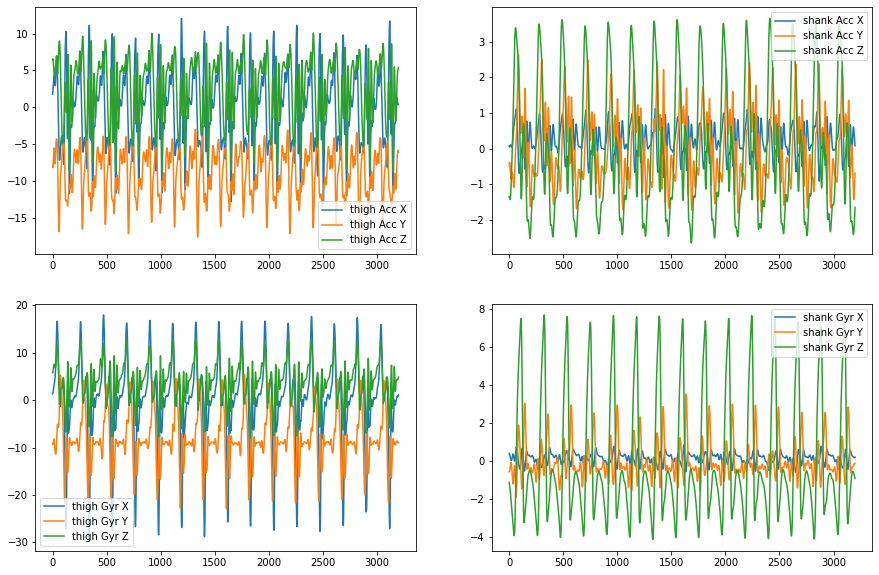

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Segment-Joint dictionary
SegJointDict = {'Hip': ['pelvis', 'thigh'], 'Knee': ['thigh', 'shank'], 'Ankle': ['shank', 'foot']}

# Load IMU data
acc1 = np.load(f'data/{activity}/{SegJointDict[joint][0]}_acc.npy')
gyr1 = np.load(f'data/{activity}/{SegJointDict[joint][0]}_gyr.npy')
acc2 = np.load(f'data/{activity}/{SegJointDict[joint][1]}_acc.npy')
gyr2 = np.load(f'data/{activity}/{SegJointDict[joint][1]}_gyr.npy')

print('\n'*2 + '#'*21 + ' Data Information ' + '#' * 21)
print(f'IMUs placement: {SegJointDict[joint][0]} and {SegJointDict[joint][1]}')
print('Measurement 1 : linear acceleration (m/s^2)')
print('Measurement 2 : angular velocity (rad/s)')
print(f'Data length   : {acc1.shape[1]/200} seconds (200 fps)')
print('#' * 60)


# Visualize IMU data
print('\n\nPlot IMUs data!\n')
plt.close('all')
fig = plt.figure(figsize=(15, 10))
for i, (acc, gyr) in enumerate(zip([acc1, gyr1], [acc2, gyr2])):
  ax_acc = fig.add_subplot(2, 2, i+1)
  ax_gyr = fig.add_subplot(2, 2, i+3)
  for j, axis in enumerate(['X', 'Y', 'Z']):
    ax_acc.plot(acc[0, :, j], label=f'{SegJointDict[joint][i]} Acc {axis}')
    ax_gyr.plot(gyr[0, :, j], label=f'{SegJointDict[joint][i]} Gyr {axis}')
  ax_acc.legend()
  ax_gyr.legend()

plt.show()

<br><br>
## Step 6. Prepare input data

Provided neural network takes inertial sensor data (accelerometer / gyroscope) from two IMUs attached on the adjacent segments. Each sensor measures has 3-dimensional data (X, Y, Z). We added the magnitude of the data as the 4th dimension. Then we normalized the data using the mean and the standard deviation of each data learned from the training set. The following code implementation shows the preprocessing procedure of input IMUs data.

In [ ]:
# Add magnitude and concatenate all features
print('\n\nPreprocess IMUs data for the network input!')
print('1. Add magnitude as new feature')
inputs = []
for data in [acc1, gyr1, acc2, gyr2]:
  mag = np.linalg.norm(data, axis=-1, keepdims=True)
  _data = np.concatenate((data, mag), axis=-1)
  inputs += [_data]
inputs = np.concatenate(inputs, axis=-1)

print('2. Convert data to PyTorch Tensor')
inputs = torch.from_numpy(inputs).to(device=device).float()

# Normalize input data
print('3. Normalize the data')
norm_dict = torch.load(f'models/checkpoints/{activity}/{joint}_norm_dict.pt')['params']
inputs = (inputs - norm_dict['x_mean']) / norm_dict['x_std']

print('\nPreprocessing completed!')
print(f'Input data shape: {inputs.shape}')



Preprocess IMUs data for the network input!
1. Add magnitude as new feature
2. Convert data to PyTorch Tensor
3. Normalize the data

Preprocessing completed!
Input data shape: torch.Size([1, 3200, 16])


<br><br>
## Step 7. Predict angle
By inputting preprocessed input data into the network (called ``model`` here), it predicts normalized joint angle. Then by un-normalizing the angle, we can obtain final joint angle prediction.

In [ ]:
from time import time

# Run inference
model.eval()
t1 = time()
pred = model(inputs)
t2 = time()

# Unnormalize prediction
pred = pred * norm_dict['y_std'] + norm_dict['y_mean']
pred = pred.detach().cpu().numpy()

print('\n\nPrediction completed!')
print('%.2f seconds taken'%(t2-t1))



Prediction completed!
0.24 seconds taken


<br><br>
## Step 8. Analize the results
Here we provide analysis of joint angle prediction. We calculate root-mean-square-error of predicted joint angle compared against ground-truth angle captured from the marker-based motion capture system. Furthermore, we visualize joint angle curve below.



########## Root-Mean-Square-Error ##########
Activity          : Walking
Joint             : Knee
RMSE-Flex/Ext     : 2.27 deg
RMSE-Add/Abd      : 1.32 deg
RMSE-Int/Ext Rot  : 1.99 deg
############################################





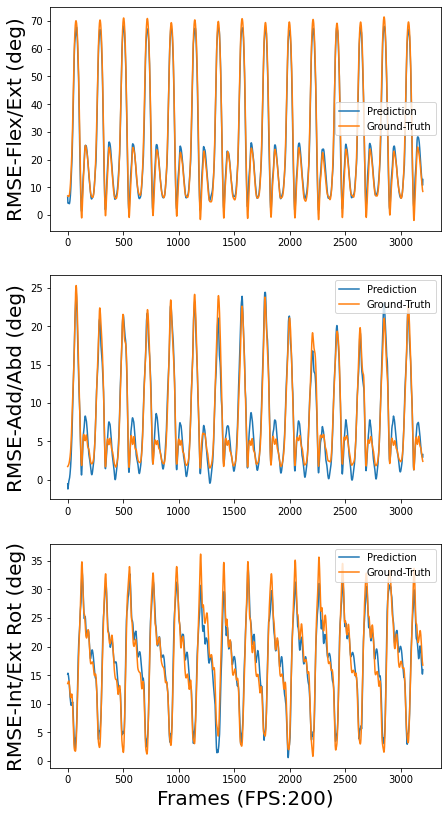

In [ ]:
# Load groundtruth
label = np.load(f'data/{activity}/{joint}_angle.npy')

# Align neutral angle (passive-pseudo calibration)
pred = pred - pred.mean(axis=1, keepdims=True) + label.mean(axis=1, keepdims=True)

# Calculate RMSE
rmse = np.sqrt(np.square(pred - label).mean(axis=1)).mean(axis=0)
print('\n'*2 + '#'*10 + ' Root-Mean-Square-Error ' + '#'*10)
print(f'Activity          : {activity}')
print(f'Joint             : {joint}')
print('RMSE-Flex/Ext     : %.2f deg'%rmse[0])
print('RMSE-Add/Abd      : %.2f deg'%rmse[1])
print('RMSE-Int/Ext Rot  : %.2f deg'%rmse[2])
print('#'*44 + '\n\n\n')


# Visualize joint angle curve
plt.close('all')
fig = plt.figure(figsize=(7, 14))

for i, axis in enumerate(['Flex/Ext', 'Add/Abd', 'Int/Ext Rot']):
  _ax = fig.add_subplot(3, 1, i+1)
  _ax.plot(pred[0, :, i], label='Prediction')
  _ax.plot(label[0, :, i], label='Ground-Truth')
  _ax.set_ylabel(f'RMSE-{axis} (deg)', fontsize=20)
  _ax.legend()
_ax.set_xlabel('Frames (FPS:200)', fontsize=20)
plt.show()